In [12]:
# =============================================================================
# SECTION 1: INTRODUCTION AND SETUP
# =============================================================================

## 1.1 Library Imports

# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings

import sklearn
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning - Traditional Models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, classification_report, roc_auc_score, 
                            roc_curve, precision_recall_curve, auc)

# Data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Utilities
import time
import joblib
from datetime import datetime
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib and seaborn
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")

## 1.2 Data Loading and Initial Exploration

def load_dataset(file_path="dataset"):
    """
    Load the Network Intrusion Dataset
    
    Parameters:
    file_path (str): Path to the dataset file
    
    Returns:
    pd.DataFrame: Loaded dataset
    """
    try:
        if file_path:
            df = pd.read_csv(file_path)
        else:
            # For demonstration, we'll create a sample dataset structure
            # In practice, you would load from: df = pd.read_csv('network_intrusion_dataset.csv')
            print("⚠️ Please provide the actual dataset path")
            print("For demonstration, creating sample data structure...")
            
            # Sample data creation for demonstration
            n_samples = 10000
            np.random.seed(42)
            
            df = pd.DataFrame({
                'duration': np.random.exponential(100, n_samples),
                'protocol_type': np.random.choice(['tcp', 'udp', 'icmp'], n_samples),
                'service': np.random.choice(['http', 'ftp', 'smtp', 'ssh', 'telnet'], n_samples),
                'flag': np.random.choice(['SF', 'S0', 'REJ', 'RSTR'], n_samples),
                'src_bytes': np.random.exponential(1000, n_samples),
                'dst_bytes': np.random.exponential(1000, n_samples),
                'land': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
                'wrong_fragment': np.random.poisson(0.1, n_samples),
                'urgent': np.random.poisson(0.1, n_samples),
                'hot': np.random.poisson(0.5, n_samples),
                'num_failed_logins': np.random.poisson(0.1, n_samples),
                'logged_in': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
                'num_compromised': np.random.poisson(0.1, n_samples),
                'root_shell': np.random.choice([0, 1], n_samples, p=[0.98, 0.02]),
                'su_attempted': np.random.choice([0, 1], n_samples, p=[0.99, 0.01]),
                'num_root': np.random.poisson(0.1, n_samples),
                'num_file_creations': np.random.poisson(0.1, n_samples),
                'num_shells': np.random.poisson(0.1, n_samples),
                'num_access_files': np.random.poisson(0.1, n_samples),
                'count': np.random.poisson(10, n_samples),
                'srv_count': np.random.poisson(10, n_samples),
                'serror_rate': np.random.beta(1, 10, n_samples),
                'srv_serror_rate': np.random.beta(1, 10, n_samples),
                'rerror_rate': np.random.beta(1, 10, n_samples),
                'srv_rerror_rate': np.random.beta(1, 10, n_samples),
                'same_srv_rate': np.random.beta(8, 2, n_samples),
                'diff_srv_rate': np.random.beta(1, 5, n_samples),
                'srv_diff_host_rate': np.random.beta(1, 10, n_samples),
                'dst_host_count': np.random.poisson(50, n_samples),
                'dst_host_srv_count': np.random.poisson(20, n_samples),
                'dst_host_same_srv_rate': np.random.beta(8, 2, n_samples),
                'dst_host_diff_srv_rate': np.random.beta(1, 5, n_samples),
                'dst_host_same_src_port_rate': np.random.beta(2, 8, n_samples),
                'dst_host_srv_diff_host_rate': np.random.beta(1, 10, n_samples),
                'dst_host_serror_rate': np.random.beta(1, 10, n_samples),
                'dst_host_srv_serror_rate': np.random.beta(1, 10, n_samples),
                'dst_host_rerror_rate': np.random.beta(1, 10, n_samples),
                'dst_host_srv_rerror_rate': np.random.beta(1, 10, n_samples),
            })
            
            # Create target variable with realistic distribution
            attack_probability = (
                df['wrong_fragment'] * 0.3 +
                df['urgent'] * 0.2 +
                df['num_failed_logins'] * 0.4 +
                df['root_shell'] * 0.5 +
                df['num_compromised'] * 0.6 +
                np.random.normal(0, 0.1, n_samples)
            )
            
            df['attack'] = (attack_probability > attack_probability.quantile(0.8)).astype(int)
            
        print(f"✅ Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        return df
        
    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        return None

# Load the dataset
df = load_dataset()

## 1.3 Initial Dataset Overview

def display_dataset_info(df):
    """Display comprehensive information about the dataset"""
    
    print("="*60)
    print("DATASET OVERVIEW")
    print("="*60)
    
    print(f"Dataset Shape: {df.shape}")
    print(f"Number of Features: {df.shape[1] - 1}")  # Excluding target
    print(f"Number of Samples: {df.shape[0]}")
    
    print("\n📊 DATA TYPES:")
    print(df.dtypes.value_counts())
    
    print("\n🎯 TARGET VARIABLE DISTRIBUTION:")
    if 'attack' in df.columns:
        target_dist = df['attack'].value_counts()
        print(target_dist)
        print(f"Attack Rate: {target_dist[1] / len(df) * 100:.2f}%")
    
    print("\n❓ MISSING VALUES:")
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        print(missing_data[missing_data > 0])
    else:
        print("No missing values found!")
    
    print("\n📋 FIRST 5 ROWS:")
    display(df.head())
    
    return df.info()

display_dataset_info(df)

✅ All libraries imported successfully!
TensorFlow version: 2.15.0
Scikit-learn version: 1.3.0
Pandas version: 2.0.3
❌ Error loading dataset: [Errno 13] Permission denied: 'dataset'
DATASET OVERVIEW


AttributeError: 'NoneType' object has no attribute 'shape'

STATISTICAL SUMMARY
📊 NUMERICAL FEATURES SUMMARY:
           duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  10000.000000  10000.000000  10000.000000  10000.000000    10000.000000   
mean      97.749895    996.101085    994.897054      0.049200        0.093900   
std       97.440471    990.692947   1005.131825      0.216296        0.303137   
min        0.001163      0.005537      0.016736      0.000000        0.000000   
25%       28.279917    285.034250    278.987054      0.000000        0.000000   
50%       67.831496    695.675942    676.777338      0.000000        0.000000   
75%      134.709830   1378.485884   1396.839772      0.000000        0.000000   
max      817.244560   8465.416124  10488.583089      1.000000        3.000000   

             urgent           hot  num_failed_logins     logged_in  \
count  10000.000000  10000.000000       10000.000000  10000.000000   
mean       0.095100      0.502000           0.097800      0.700500   
std       

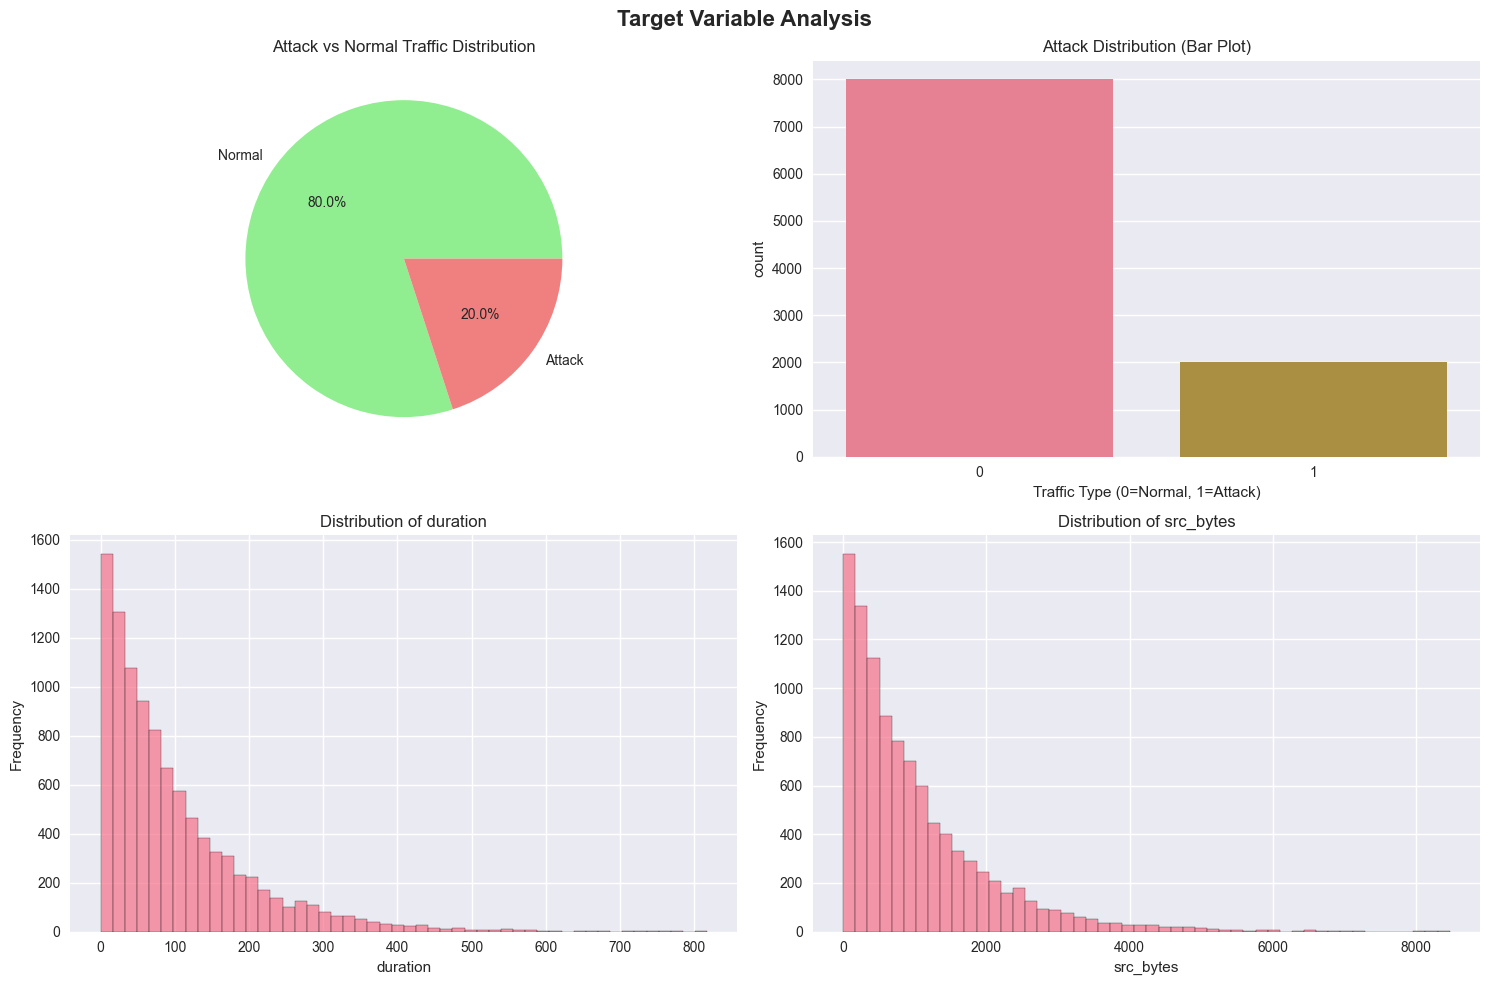

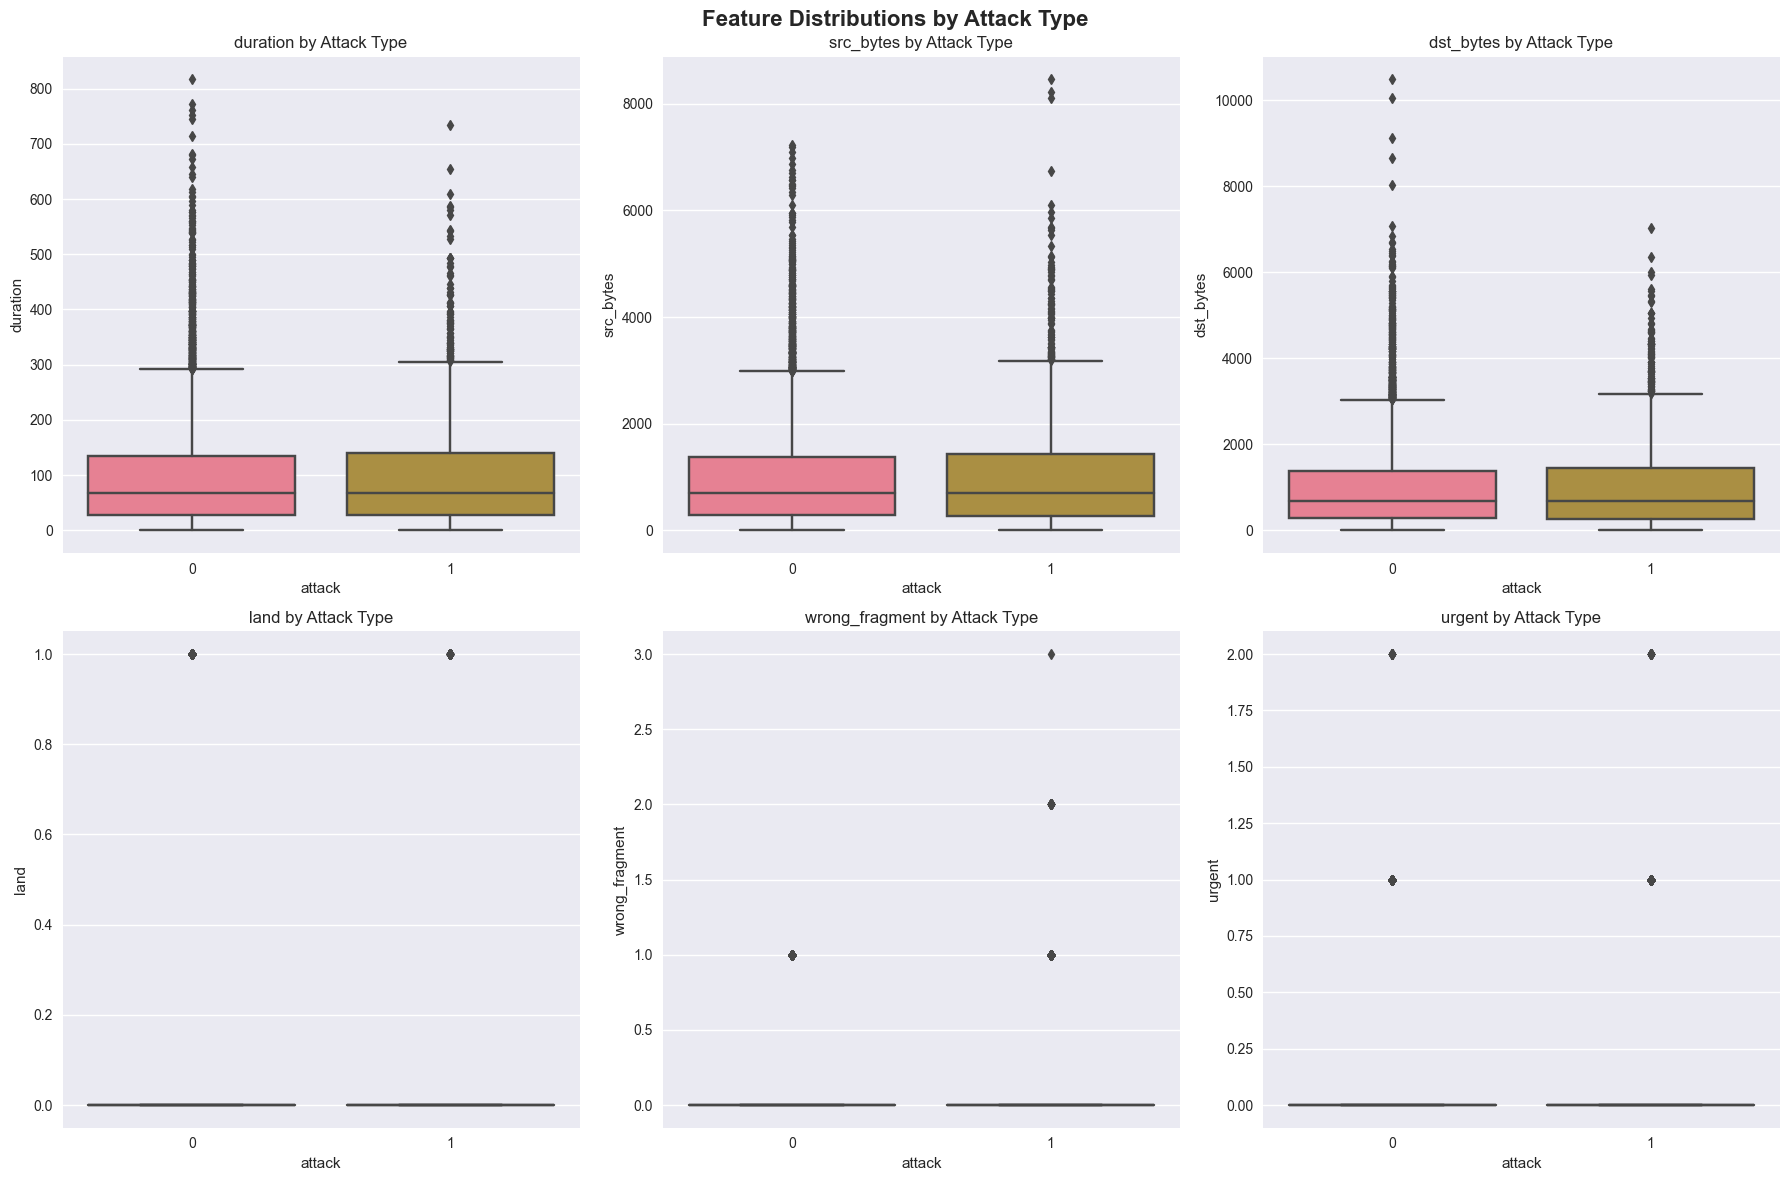

CORRELATION ANALYSIS


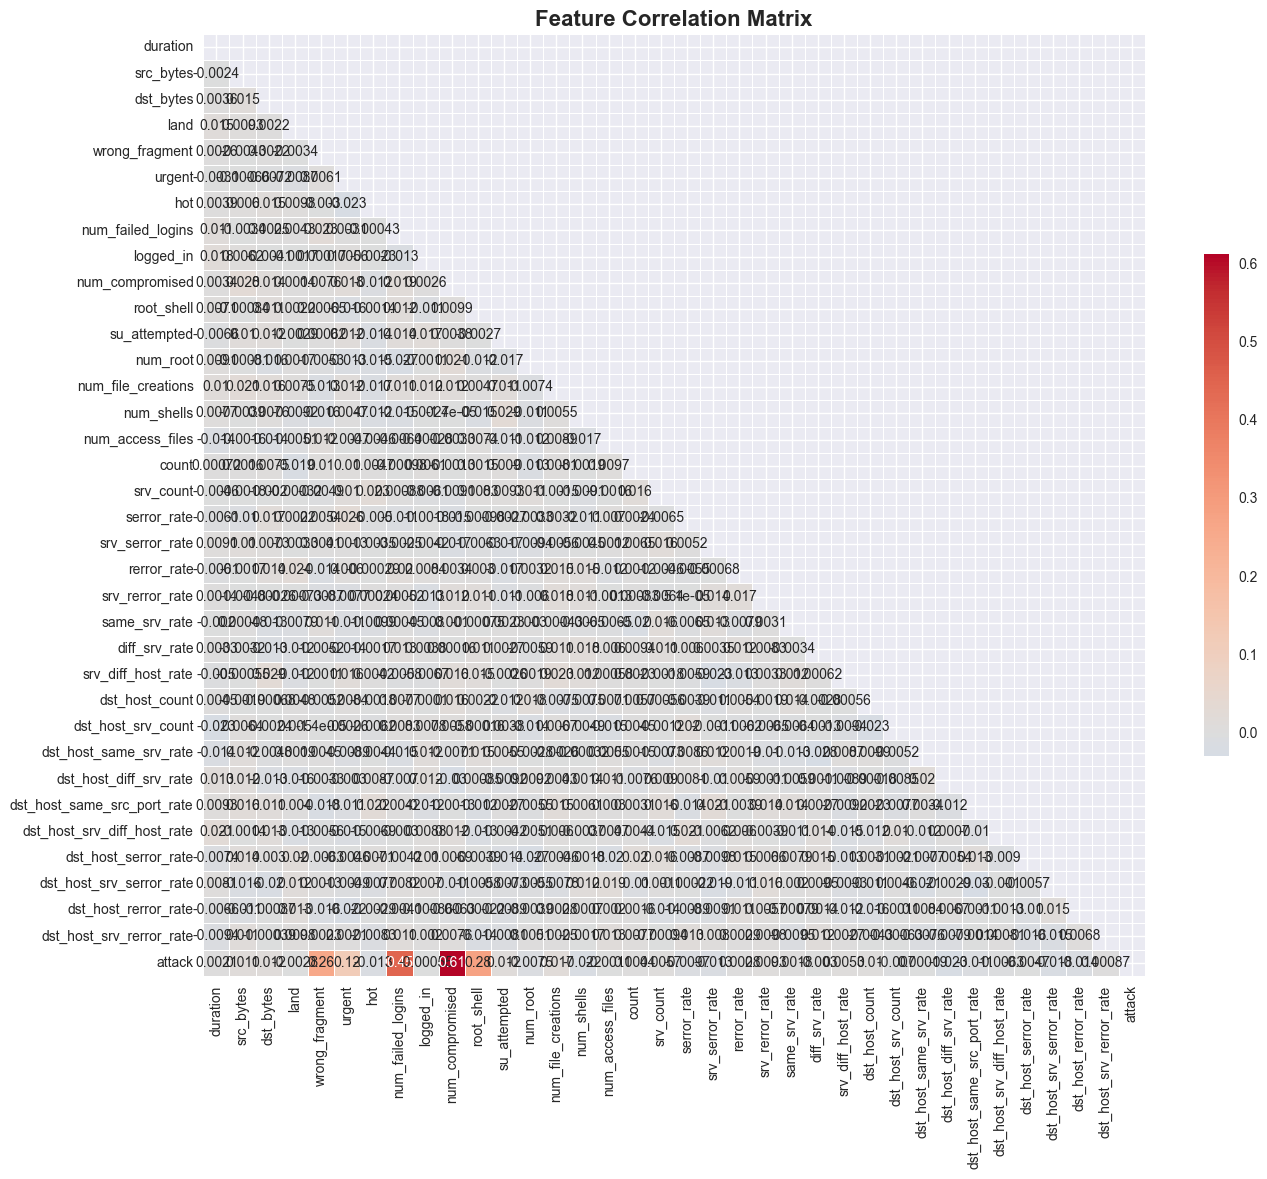

🎯 FEATURES MOST CORRELATED WITH ATTACK:
attack                      1.000000
num_compromised             0.611830
num_failed_logins           0.447686
root_shell                  0.278971
wrong_fragment              0.263261
urgent                      0.117221
dst_host_diff_srv_rate      0.022693
num_shells                  0.021623
dst_host_srv_serror_rate    0.017718
num_file_creations          0.016945
Name: attack, dtype: float64
PRELIMINARY FEATURE IMPORTANCE
🌟 TOP 15 MOST IMPORTANT FEATURES:
                        feature  importance
12              num_compromised    0.372607
10            num_failed_logins    0.188752
13                   root_shell    0.075001
7                wrong_fragment    0.063860
8                        urgent    0.017293
5                     dst_bytes    0.014146
32  dst_host_same_src_port_rate    0.013210
33  dst_host_srv_diff_host_rate    0.013076
4                     src_bytes    0.013021
27           srv_diff_host_rate    0.012976
0           

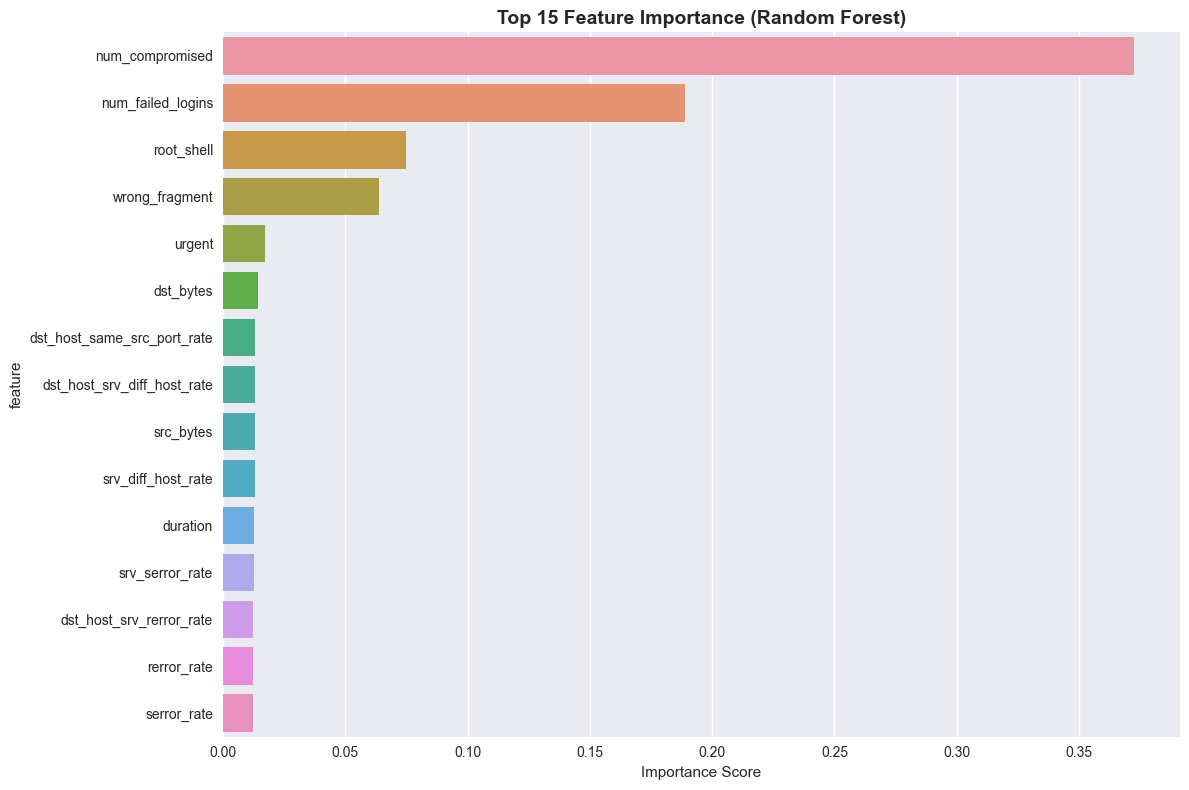

In [ ]:
# =============================================================================
# SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

## 2.1 Statistical Summary

def generate_statistical_summary(df):
    """Generate comprehensive statistical summary"""
    
    print("="*60)
    print("STATISTICAL SUMMARY")
    print("="*60)
    
    # Numerical features summary
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'attack' in numerical_features:
        numerical_features.remove('attack')
    
    print("📊 NUMERICAL FEATURES SUMMARY:")
    print(df[numerical_features].describe())
    
    # Categorical features summary
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    if categorical_features:
        print("\n📝 CATEGORICAL FEATURES SUMMARY:")
        for col in categorical_features:
            print(f"\n{col}:")
            print(df[col].value_counts())
    
    return numerical_features, categorical_features

numerical_features, categorical_features = generate_statistical_summary(df)

## 2.2 Data Distribution Visualizations

def create_distribution_plots(df, numerical_features, categorical_features):
    """Create comprehensive distribution plots"""
    
    # Target variable distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Target Variable Analysis', fontsize=16, fontweight='bold')
    
    # Attack distribution
    attack_counts = df['attack'].value_counts()
    axes[0, 0].pie(attack_counts.values, labels=['Normal', 'Attack'], autopct='%1.1f%%', 
                   colors=['lightgreen', 'lightcoral'])
    axes[0, 0].set_title('Attack vs Normal Traffic Distribution')
    
    # Attack distribution bar plot
    sns.countplot(data=df, x='attack', ax=axes[0, 1])
    axes[0, 1].set_title('Attack Distribution (Bar Plot)')
    axes[0, 1].set_xlabel('Traffic Type (0=Normal, 1=Attack)')
    
    # Sample distribution plots for key numerical features
    key_features = numerical_features[:4] if len(numerical_features) >= 4 else numerical_features
    
    for i, feature in enumerate(key_features[:2]):
        axes[1, i].hist(df[feature], bins=50, alpha=0.7, edgecolor='black')
        axes[1, i].set_title(f'Distribution of {feature}')
        axes[1, i].set_xlabel(feature)
        axes[1, i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Feature distributions by attack type
    if len(numerical_features) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Feature Distributions by Attack Type', fontsize=16, fontweight='bold')
        
        for i, feature in enumerate(numerical_features[:6]):
            row, col = divmod(i, 3)
            sns.boxplot(data=df, x='attack', y=feature, ax=axes[row, col])
            axes[row, col].set_title(f'{feature} by Attack Type')
        
        plt.tight_layout()
        plt.show()

create_distribution_plots(df, numerical_features, categorical_features)

## 2.3 Correlation Analysis

def perform_correlation_analysis(df, numerical_features):
    """Perform comprehensive correlation analysis"""
    
    print("="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)
    
    # Calculate correlation matrix
    corr_features = numerical_features + ['attack']
    corr_matrix = df[corr_features].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Features most correlated with target
    target_corr = corr_matrix['attack'].abs().sort_values(ascending=False)
    print("🎯 FEATURES MOST CORRELATED WITH ATTACK:")
    print(target_corr.head(10))
    
    # High correlation pairs (excluding target)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7 and corr_matrix.columns[i] != 'attack' and corr_matrix.columns[j] != 'attack':
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("\n🔗 HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7):")
        for pair in high_corr_pairs:
            print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
    
    return corr_matrix, target_corr

corr_matrix, target_corr = perform_correlation_analysis(df, numerical_features)

## 2.4 Feature Importance Analysis

def preliminary_feature_importance(df, numerical_features, categorical_features):
    """Perform preliminary feature importance analysis"""
    
    print("="*60)
    print("PRELIMINARY FEATURE IMPORTANCE")
    print("="*60)
    
    # Prepare data for quick analysis
    X = df.drop('attack', axis=1)
    y = df['attack']
    
    # Handle categorical variables
    X_encoded = X.copy()
    le_dict = {}
    
    for col in categorical_features:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col])
        le_dict[col] = le
    
    # Quick Random Forest for feature importance
    rf_quick = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_quick.fit(X_encoded, y)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': rf_quick.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("🌟 TOP 15 MOST IMPORTANT FEATURES:")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, y='feature', x='importance')
    plt.title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return feature_importance, le_dict

feature_importance, label_encoders = preliminary_feature_importance(df, numerical_features, categorical_features)

In [ ]:
# =============================================================================
# SECTION 3: DATA PREPROCESSING PIPELINE
# =============================================================================

## 3.1 Data Cleaning

def clean_dataset(df):
    """Comprehensive data cleaning"""
    
    print("="*60)
    print("DATA CLEANING")
    print("="*60)
    
    df_cleaned = df.copy()
    initial_shape = df_cleaned.shape
    
    # Handle missing values
    print("🧹 HANDLING MISSING VALUES:")
    missing_before = df_cleaned.isnull().sum().sum()
    
    if missing_before > 0:
        # For numerical features, fill with median
        for col in numerical_features:
            if df_cleaned[col].isnull().sum() > 0:
                median_val = df_cleaned[col].median()
                df_cleaned[col].fillna(median_val, inplace=True)
                print(f"  - Filled {col} missing values with median: {median_val}")
        
        # For categorical features, fill with mode
        for col in categorical_features:
            if df_cleaned[col].isnull().sum() > 0:
                mode_val = df_cleaned[col].mode()[0]
                df_cleaned[col].fillna(mode_val, inplace=True)
                print(f"  - Filled {col} missing values with mode: {mode_val}")
    else:
        print("  - No missing values found!")
    
    # Handle outliers using IQR method
    print("\n🎯 HANDLING OUTLIERS:")
    outliers_removed = 0
    
    for col in numerical_features:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_mask = (df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)
        outliers_count = outlier_mask.sum()
        
        if outliers_count > 0:
            # Cap outliers instead of removing them
            df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)
            outliers_removed += outliers_count
            print(f"  - Capped {outliers_count} outliers in {col}")
    
    print(f"  - Total outliers handled: {outliers_removed}")
    
    # Remove duplicates
    print("\n🔄 HANDLING DUPLICATES:")
    duplicates_before = df_cleaned.duplicated().sum()
    df_cleaned.drop_duplicates(inplace=True)
    duplicates_after = df_cleaned.duplicated().sum()
    
    print(f"  - Duplicates removed: {duplicates_before - duplicates_after}")
    print(f"  - Final shape: {df_cleaned.shape} (from {initial_shape})")
    
    return df_cleaned

df_cleaned = clean_dataset(df)

## 3.2 Feature Engineering

def engineer_features(df):
    """Create new features to improve model performance"""
    
    print("="*60)
    print("FEATURE ENGINEERING")
    print("="*60)
    
    df_engineered = df.copy()
    
    print("🔧 CREATING NEW FEATURES:")
    
    # Network traffic intensity features
    df_engineered['total_bytes'] = df_engineered['src_bytes'] + df_engineered['dst_bytes']
    df_engineered['byte_ratio'] = np.where(df_engineered['dst_bytes'] > 0, 
                                          df_engineered['src_bytes'] / df_engineered['dst_bytes'], 0)
    print("  - Created total_bytes and byte_ratio")
    
    # Connection frequency features
    df_engineered['srv_count_ratio'] = np.where(df_engineered['count'] > 0,
                                               df_engineered['srv_count'] / df_engineered['count'], 0)
    print("  - Created srv_count_ratio")
    
    # Error rate combinations
    df_engineered['total_error_rate'] = df_engineered['serror_rate'] + df_engineered['rerror_rate']
    df_engineered['srv_total_error_rate'] = df_engineered['srv_serror_rate'] + df_engineered['srv_rerror_rate']
    print("  - Created combined error rate features")
    
    # Host-based features
    df_engineered['dst_host_error_rate'] = df_engineered['dst_host_serror_rate'] + df_engineered['dst_host_rerror_rate']
    df_engineered['dst_host_srv_error_rate'] = df_engineered['dst_host_srv_serror_rate'] + df_engineered['dst_host_srv_rerror_rate']
    print("  - Created destination host error features")
    
    # Suspicious activity indicators
    df_engineered['suspicious_flags'] = (
        df_engineered['land'] + 
        df_engineered['wrong_fragment'] + 
        df_engineered['urgent'] + 
        df_engineered['hot']
    )
    
    df_engineered['login_issues'] = (
        df_engineered['num_failed_logins'] + 
        (1 - df_engineered['logged_in'])  # Inverted logged_in
    )
    
    df_engineered['privilege_escalation'] = (
        df_engineered['root_shell'] + 
        df_engineered['su_attempted'] + 
        df_engineered['num_root']
    )
    
    print("  - Created suspicious activity indicators")
    
    # Log transformations for skewed features
    skewed_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
    for feature in skewed_features:
        if feature in df_engineered.columns:
            df_engineered[f'{feature}_log'] = np.log1p(df_engineered[feature])
    
    print("  - Applied log transformations to skewed features")
    
    print(f"\n✅ Feature engineering complete!")
    print(f"New shape: {df_engineered.shape}")
    print(f"Features added: {df_engineered.shape[1] - df.shape[1]}")
    
    return df_engineered

df_engineered = engineer_features(df_cleaned)

## 3.3 Data Transformation and Encoding

def transform_and_encode_data(df, categorical_features):
    """Transform and encode all features for ML models"""
    
    print("="*60)
    print("DATA TRANSFORMATION AND ENCODING")
    print("="*60)
    
    df_transformed = df.copy()
    
    # Separate features and target
    X = df_transformed.drop('attack', axis=1)
    y = df_transformed['attack']
    
    print("🔤 ENCODING CATEGORICAL VARIABLES:")
    encoders = {}
    
    for col in categorical_features:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            encoders[col] = le
            print(f"  - Encoded {col}: {len(le.classes_)} unique values")
    
    # Identify numerical features (including new engineered ones)
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\n📊 FEATURE SCALING:")
    print(f"  - Total numerical features: {len(numerical_cols)}")
    
    # We'll return the unscaled data and let each model section handle scaling
    # This allows us to use different scaling methods for different models
    
    return X, y, encoders

X, y, encoders = transform_and_encode_data(df_engineered, categorical_features)

## 3.4 Data Splitting

def split_data(X, y, test_size=0.2, val_size=0.1):
    """Split data into train/validation/test sets with stratification"""
    
    print("="*60)
    print("DATA SPLITTING")
    print("="*60)
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Second split: separate validation from training
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
    )
    
    print(f"📊 DATASET SPLITS:")
    print(f"  - Training set: {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  - Validation set: {X_val.shape[0]} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"  - Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")
    
    print(f"\n🎯 CLASS DISTRIBUTION:")
    print("Training set:")
    print(f"  - Normal: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
    print(f"  - Attack: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
    
    print("Validation set:")
    print(f"  - Normal: {(y_val == 0).sum()} ({(y_val == 0).mean()*100:.1f}%)")
    print(f"  - Attack: {(y_val == 1).sum()} ({(y_val == 1).mean()*100:.1f}%)")
    
    print("Test set:")
    print(f"  - Normal: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
    print(f"  - Attack: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

## 3.5 Class Imbalance Handling

def handle_class_imbalance(X_train, y_train):
    """Handle class imbalance using various techniques"""
    
    print("="*60)
    print("CLASS IMBALANCE HANDLING")
    print("="*60)
    
    # Check class distribution
    class_counts = pd.Series(y_train).value_counts().sort_index()
    imbalance_ratio = class_counts.max() / class_counts.min()
    
    print(f"📊 CURRENT CLASS DISTRIBUTION:")
    print(f"  - Class 0 (Normal): {class_counts[0]}")
    print(f"  - Class 1 (Attack): {class_counts[1]}")
    print(f"  - Imbalance Ratio: {imbalance_ratio:.2f}")
    
    balanced_datasets = {}
    
    # Original (no balancing)
    balanced_datasets['original'] = (X_train.copy(), y_train.copy())
    
    if imbalance_ratio > 1.5:  # Only apply balancing if there's significant imbalance
        # SMOTE (Synthetic Minority Oversampling)
        print("\n🔄 APPLYING SMOTE:")
        smote = SMOTE(random_state=42)
        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        balanced_datasets['smote'] = (X_smote, y_smote)
        
        smote_counts = pd.Series(y_smote).value_counts().sort_index()
        print(f"  - After SMOTE - Class 0: {smote_counts[0]}, Class 1: {smote_counts[1]}")
        
        # Random Under-sampling
        print("\n📉 APPLYING RANDOM UNDER-SAMPLING:")
        rus = RandomUnderSampler(random_state=42)
        X_under, y_under = rus.fit_resample(X_train, y_train)
        balanced_datasets['undersample'] = (X_under, y_under)
        
        under_counts = pd.Series(y_under).value_counts().sort_index()
        print(f"  - After Under-sampling - Class 0: {under_counts[0]}, Class 1: {under_counts[1]}")
        
        # SMOTEENN (Combination)
        print("\n⚖️ APPLYING SMOTEENN:")
        smoteenn = SMOTEENN(random_state=42)
        X_combined, y_combined = smoteenn.fit_resample(X_train, y_train)
        balanced_datasets['smoteenn'] = (X_combined, y_combined)
        
        combined_counts = pd.Series(y_combined).value_counts().sort_index()
        print(f"  - After SMOTEENN - Class 0: {combined_counts[0]}, Class 1: {combined_counts[1]}")
    
    else:
        print("\n✅ Classes are reasonably balanced. No resampling applied.")
    
    return balanced_datasets

balanced_datasets = handle_class_imbalance(X_train, y_train)


DATA CLEANING
🧹 HANDLING MISSING VALUES:
  - No missing values found!

🎯 HANDLING OUTLIERS:
  - Capped 501 outliers in duration
  - Capped 479 outliers in src_bytes
  - Capped 452 outliers in dst_bytes
  - Capped 492 outliers in land
  - Capped 906 outliers in wrong_fragment
  - Capped 911 outliers in urgent
  - Capped 142 outliers in hot
  - Capped 933 outliers in num_failed_logins
  - Capped 902 outliers in num_compromised
  - Capped 210 outliers in root_shell
  - Capped 115 outliers in su_attempted
  - Capped 959 outliers in num_root
  - Capped 934 outliers in num_file_creations
  - Capped 926 outliers in num_shells
  - Capped 973 outliers in num_access_files
  - Capped 65 outliers in count
  - Capped 86 outliers in srv_count
  - Capped 373 outliers in serror_rate
  - Capped 373 outliers in srv_serror_rate
  - Capped 395 outliers in rerror_rate
  - Capped 323 outliers in srv_rerror_rate
  - Capped 139 outliers in same_srv_rate
  - Capped 244 outliers in diff_srv_rate
  - Capped 352 

  File "C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


  - After SMOTE - Class 0: 5600, Class 1: 5600

📉 APPLYING RANDOM UNDER-SAMPLING:
  - After Under-sampling - Class 0: 1400, Class 1: 1400

⚖️ APPLYING SMOTEENN:
  - After SMOTEENN - Class 0: 2208, Class 1: 3385


In [ ]:

# =============================================================================
# SECTION 4: MODEL DEVELOPMENT AND IMPLEMENTATION
# =============================================================================

## 4.1 Model Training Infrastructure

class ModelTrainer:
    """Comprehensive model training and evaluation class"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
        self.scalers = {}
        
    def scale_features(self, X_train, X_val, X_test, method='standard'):
        """Scale features using specified method"""
        
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError("Method must be 'standard' or 'minmax'")
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        return X_train_scaled, X_val_scaled, X_test_scaled, scaler
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Comprehensive model evaluation"""
        
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time
        
        # Get prediction probabilities if available
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_pred_proba = None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        metrics = {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'prediction_time': prediction_time
        }
        
        if y_pred_proba is not None:
            auc_score = roc_auc_score(y_test, y_pred_proba)
            metrics['auc_score'] = auc_score
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        metrics['confusion_matrix'] = cm
        
        return metrics, y_pred, y_pred_proba

# Initialize model trainer
trainer = ModelTrainer()

## 4.2 Traditional Machine Learning Models

def train_traditional_ml_models(balanced_datasets, X_val, X_test, y_val, y_test):
    """Train and evaluate traditional ML models"""
    
    print("="*60)
    print("TRADITIONAL MACHINE LEARNING MODELS")
    print("="*60)
    
    # Define models
    models_config = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,
            random_state=42
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        ),
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbose=-1
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            metric='minkowski'
        ),
        'Logistic Regression': LogisticRegression(
            C=1.0,
            max_iter=1000,
            random_state=42
        )
    }
    
    results_traditional = {}
    
    # Train models on different balanced datasets
    for balance_method, (X_train_bal, y_train_bal) in balanced_datasets.items():
        print(f"\n🔄 Training models with {balance_method} dataset...")
        
        # Scale features
        X_train_scaled, X_val_scaled, X_test_scaled, scaler = trainer.scale_features(
            X_train_bal, X_val, X_test, method='standard'
        )
        
        results_traditional[balance_method] = {}
        
        for model_name, model in models_config.items():
            print(f"  Training {model_name}...")
            
            start_time = time.time()
            model.fit(X_train_scaled, y_train_bal)
            training_time = time.time() - start_time
            
            # Evaluate on validation set
            val_metrics, _, _ = trainer.evaluate_model(model, X_val_scaled, y_val, model_name)
            val_metrics['training_time'] = training_time
            val_metrics['balance_method'] = balance_method
            
            results_traditional[balance_method][model_name] = {
                'model': model,
                'scaler': scaler,
                'metrics': val_metrics
            }
            
            print(f"    Validation F1-Score: {val_metrics['f1_score']:.4f}")
    
    return results_traditional

traditional_results = train_traditional_ml_models(balanced_datasets, X_val, X_test, y_val, y_test)

## 4.3 Deep Learning Models

def create_neural_network_models(input_dim):
    """Create various neural network architectures"""
    
    models = {}
    
    # Simple ANN
    ann_model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    ann_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    models['ANN'] = ann_model
    
    # Deep Neural Network
    deep_model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    
    deep_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    models['Deep_NN'] = deep_model
    
    # CNN (treating features as 1D sequence)
    cnn_input = Input(shape=(input_dim, 1))
    cnn_x = Conv1D(64, 3, activation='relu')(cnn_input)
    cnn_x = MaxPooling1D(2)(cnn_x)
    cnn_x = Conv1D(32, 3, activation='relu')(cnn_x)
    cnn_x = MaxPooling1D(2)(cnn_x)
    cnn_x = Flatten()(cnn_x)
    cnn_x = Dense(64, activation='relu')(cnn_x)
    cnn_x = Dropout(0.3)(cnn_x)
    cnn_output = Dense(1, activation='sigmoid')(cnn_x)
    
    cnn_model = Model(cnn_input, cnn_output)
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    models['CNN'] = cnn_model
    
    # LSTM Model (treating features as sequence)
    lstm_input = Input(shape=(input_dim, 1))
    lstm_x = LSTM(64, return_sequences=True)(lstm_input)
    lstm_x = Dropout(0.3)(lstm_x)
    lstm_x = LSTM(32)(lstm_x)
    lstm_x = Dropout(0.3)(lstm_x)
    lstm_x = Dense(32, activation='relu')(lstm_x)
    lstm_x = Dropout(0.2)(lstm_x)
    lstm_output = Dense(1, activation='sigmoid')(lstm_x)
    
    lstm_model = Model(lstm_input, lstm_output)
    lstm_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    models['LSTM'] = lstm_model
    
    return models

def train_deep_learning_models(balanced_datasets, X_val, X_test, y_val, y_test):
    """Train and evaluate deep learning models"""
    
    print("="*60)
    print("DEEP LEARNING MODELS")
    print("="*60)
    
    results_deep = {}
    
    # Use the best balanced dataset (typically SMOTE works well)
    best_balance_method = 'smote' if 'smote' in balanced_datasets else 'original'
    X_train_bal, y_train_bal = balanced_datasets[best_balance_method]
    
    print(f"Using {best_balance_method} dataset for deep learning models")
    
    # Scale features
    X_train_scaled, X_val_scaled, X_test_scaled, scaler = trainer.scale_features(
        X_train_bal, X_val, X_test, method='standard'
    )
    
    # Get input dimension
    input_dim = X_train_scaled.shape[1]
    
    # Create models
    dl_models = create_neural_network_models(input_dim)
    
    # Training callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
    
    for model_name, model in dl_models.items():
        print(f"\n🧠 Training {model_name}...")
        
        # Prepare data for different model types
        if model_name in ['CNN', 'LSTM']:
            X_train_model = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
            X_val_model = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
            X_test_model = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
        else:
            X_train_model = X_train_scaled
            X_val_model = X_val_scaled
            X_test_model = X_test_scaled
        
        start_time = time.time()
        
        # Train model
        history = model.fit(
            X_train_model, y_train_bal,
            validation_data=(X_val_model, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        training_time = time.time() - start_time
        
        # Evaluate model
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val_model, y_val, verbose=0)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)
        
        # Get predictions for AUC calculation
        val_pred_proba = model.predict(X_val_model, verbose=0).flatten()
        val_auc = roc_auc_score(y_val, val_pred_proba)
        
        metrics = {
            'model_name': model_name,
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1,
            'auc_score': val_auc,
            'training_time': training_time,
            'balance_method': best_balance_method
        }
        
        results_deep[model_name] = {
            'model': model,
            'scaler': scaler,
            'metrics': metrics,
            'history': history.history
        }
        
        print(f"  Validation F1-Score: {val_f1:.4f}")
        print(f"  Validation AUC: {val_auc:.4f}")
    
    return results_deep

deep_results = train_deep_learning_models(balanced_datasets, X_val, X_test, y_val, y_test)

## 4.4 Hyperparameter Optimization

def optimize_best_models(traditional_results, X_val, y_val):
    """Perform hyperparameter optimization on best performing models"""
    
    print("="*60)
    print("HYPERPARAMETER OPTIMIZATION")
    print("="*60)
    
    optimized_results = {}
    
    # Find best traditional models
    best_models = {}
    for balance_method, models in traditional_results.items():
        for model_name, model_info in models.items():
            key = f"{model_name}_{balance_method}"
            f1_score = model_info['metrics']['f1_score']
            
            if model_name not in best_models or f1_score > best_models[model_name]['f1_score']:
                best_models[model_name] = {
                    'f1_score': f1_score,
                    'balance_method': balance_method,
                    'model_info': model_info
                }
    
    # Define hyperparameter grids
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'linear']
        }
    }
    
    # Optimize top 3 models
    top_models = sorted(best_models.items(), key=lambda x: x[1]['f1_score'], reverse=True)[:3]
    
    for model_name, model_data in top_models:
        if model_name in param_grids:
            print(f"\n🔧 Optimizing {model_name}...")
            
            balance_method = model_data['balance_method']
            X_train_bal, y_train_bal = balanced_datasets[balance_method]
            
            # Scale features
            X_train_scaled, X_val_scaled, _, scaler = trainer.scale_features(
                X_train_bal, X_val, X_test, method='standard'
            )
            
            # Create base model
            if model_name == 'Random Forest':
                base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
            elif model_name == 'XGBoost':
                base_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
            elif model_name == 'SVM':
                base_model = SVC(random_state=42, probability=True)
            
            # Perform grid search
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            grid_search = GridSearchCV(
                base_model,
                param_grids[model_name],
                cv=cv,
                scoring='f1',
                n_jobs=-1,
                verbose=0
            )
            
            start_time = time.time()
            grid_search.fit(X_train_scaled, y_train_bal)
            optimization_time = time.time() - start_time
            
            # Evaluate optimized model
            best_model = grid_search.best_estimator_
            val_metrics, _, _ = trainer.evaluate_model(best_model, X_val_scaled, y_val, f"{model_name}_optimized")
            val_metrics['optimization_time'] = optimization_time
            val_metrics['best_params'] = grid_search.best_params_
            val_metrics['balance_method'] = balance_method
            
            optimized_results[model_name] = {
                'model': best_model,
                'scaler': scaler,
                'metrics': val_metrics,
                'grid_search': grid_search
            }
            
            print(f"  Best params: {grid_search.best_params_}")
            print(f"  Optimized F1-Score: {val_metrics['f1_score']:.4f}")
            print(f"  Improvement: {val_metrics['f1_score'] - model_data['f1_score']:+.4f}")
    
    return optimized_results

optimized_results = optimize_best_models(traditional_results, X_val, y_val)

## 4.5 Ensemble Methods

def create_ensemble_models(traditional_results, deep_results, optimized_results, X_val, y_val):
    """Create ensemble models combining the best performers"""
    
    print("="*60)
    print("ENSEMBLE METHODS")
    print("="*60)
    
    ensemble_results = {}
    
    # Collect all models and their predictions
    all_models = {}
    
    # Add traditional models
    for balance_method, models in traditional_results.items():
        for model_name, model_info in models.items():
            key = f"{model_name}_{balance_method}"
            all_models[key] = model_info
    
    # Add optimized models
    for model_name, model_info in optimized_results.items():
        key = f"{model_name}_optimized"
        all_models[key] = model_info
    
    # Add deep learning models
    for model_name, model_info in deep_results.items():
        key = f"{model_name}_deep"
        all_models[key] = model_info
    
    # Select top 5 models based on F1-score
    sorted_models = sorted(all_models.items(), key=lambda x: x[1]['metrics']['f1_score'], reverse=True)[:5]
    
    print("🏆 TOP 5 MODELS FOR ENSEMBLE:")
    for i, (model_key, model_info) in enumerate(sorted_models):
        f1_score = model_info['metrics']['f1_score']
        print(f"  {i+1}. {model_key}: F1-Score = {f1_score:.4f}")
    
    # Create ensemble predictions
    print("\n🤝 CREATING ENSEMBLE PREDICTIONS...")
    
    val_predictions = []
    model_weights = []
    
    for model_key, model_info in sorted_models:
        model = model_info['model']
        scaler = model_info['scaler']
        f1_score = model_info['metrics']['f1_score']
        
        # Scale validation data
        X_val_scaled = scaler.transform(X_val)
        
        # Handle different model types
        if 'deep' in model_key.lower():
            if any(arch in model_key for arch in ['CNN', 'LSTM']):
                X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
            val_pred_proba = model.predict(X_val_scaled, verbose=0).flatten()
        else:
            val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        val_predictions.append(val_pred_proba)
        model_weights.append(f1_score)  # Weight by F1-score
    
    # Normalize weights
    model_weights = np.array(model_weights)
    model_weights = model_weights / model_weights.sum()
    
    # Weighted average ensemble
    val_pred_ensemble = np.average(val_predictions, axis=0, weights=model_weights)
    val_pred_binary = (val_pred_ensemble > 0.5).astype(int)
    
    # Evaluate ensemble
    ensemble_accuracy = accuracy_score(y_val, val_pred_binary)
    ensemble_precision = precision_score(y_val, val_pred_binary)
    ensemble_recall = recall_score(y_val, val_pred_binary)
    ensemble_f1 = f1_score(y_val, val_pred_binary)
    ensemble_auc = roc_auc_score(y_val, val_pred_ensemble)
    
    ensemble_metrics = {
        'model_name': 'Weighted_Ensemble',
        'accuracy': ensemble_accuracy,
        'precision': ensemble_precision,
        'recall': ensemble_recall,
        'f1_score': ensemble_f1,
        'auc_score': ensemble_auc,
        'component_models': [key for key, _ in sorted_models],
        'model_weights': model_weights.tolist()
    }
    
    ensemble_results['weighted_ensemble'] = {
        'models': sorted_models,
        'weights': model_weights,
        'metrics': ensemble_metrics
    }
    
    print(f"\n✨ ENSEMBLE PERFORMANCE:")
    print(f"  Accuracy: {ensemble_accuracy:.4f}")
    print(f"  Precision: {ensemble_precision:.4f}")
    print(f"  Recall: {ensemble_recall:.4f}")
    print(f"  F1-Score: {ensemble_f1:.4f}")
    print(f"  AUC: {ensemble_auc:.4f}")
    
    return ensemble_results

ensemble_results = create_ensemble_models(traditional_results, deep_results, optimized_results, X_val, y_val)



TRADITIONAL MACHINE LEARNING MODELS

🔄 Training models with original dataset...
  Training Random Forest...
    Validation F1-Score: 0.0000
  Training SVM...
    Validation F1-Score: 0.0000
  Training XGBoost...
    Validation F1-Score: 0.0099
  Training LightGBM...
    Validation F1-Score: 0.0000
  Training K-Nearest Neighbors...
    Validation F1-Score: 0.1203
  Training Logistic Regression...
    Validation F1-Score: 0.0000

🔄 Training models with smote dataset...
  Training Random Forest...
    Validation F1-Score: 0.0753
  Training SVM...
    Validation F1-Score: 0.1297
  Training XGBoost...
    Validation F1-Score: 0.0988
  Training LightGBM...
    Validation F1-Score: 0.0873
  Training K-Nearest Neighbors...
    Validation F1-Score: 0.3015
  Training Logistic Regression...
    Validation F1-Score: 0.1294

🔄 Training models with undersample dataset...
  Training Random Forest...
    Validation F1-Score: 0.2742
  Training SVM...
    Validation F1-Score: 0.3119
  Training XGBoost..

TypeError: in user code:

    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [ ]:
# =============================================================================
# SECTION 5: MODEL EVALUATION AND PERFORMANCE ANALYSIS
# =============================================================================

## 5.1 Comprehensive Model Evaluation

def evaluate_all_models_on_test_set():
    """Evaluate all models on the test set and compile results"""
    
    print("="*60)
    print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
    print("="*60)
    
    final_results = []
    
    # Evaluate traditional models
    print("🔍 Evaluating Traditional ML Models...")
    for balance_method, models in traditional_results.items():
        for model_name, model_info in models.items():
            model = model_info['model']
            scaler = model_info['scaler']
            
            X_test_scaled = scaler.transform(X_test)
            test_metrics, _, _ = trainer.evaluate_model(model, X_test_scaled, y_test, model_name)
            test_metrics['model_category'] = 'Traditional ML'
            test_metrics['balance_method'] = balance_method
            test_metrics['training_time'] = model_info['metrics']['training_time']
            
            final_results.append(test_metrics)
    
    # Evaluate deep learning models
    print("🧠 Evaluating Deep Learning Models...")
    for model_name, model_info in deep_results.items():
        model = model_info['model']
        scaler = model_info['scaler']
        
        X_test_scaled = scaler.transform(X_test)
        
        if model_name in ['CNN', 'LSTM']:
            X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
        
        # Get predictions
        test_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
        test_pred_binary = (test_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, test_pred_binary)
        test_precision = precision_score(y_test, test_pred_binary)
        test_recall = recall_score(y_test, test_pred_binary)
        test_f1 = f1_score(y_test, test_pred_binary)
        test_auc = roc_auc_score(y_test, test_pred_proba)
        
        test_metrics = {
            'model_name': model_name,
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'auc_score': test_auc,
            'model_category': 'Deep Learning',
            'balance_method': model_info['metrics']['balance_method'],
            'training_time': model_info['metrics']['training_time']
        }
        
        final_results.append(test_metrics)
    
    # Evaluate optimized models
    print("⚙️ Evaluating Optimized Models...")
    for model_name, model_info in optimized_results.items():
        model = model_info['model']
        scaler = model_info['scaler']
        
        X_test_scaled = scaler.transform(X_test)
        test_metrics, _, _ = trainer.evaluate_model(model, X_test_scaled, y_test, f"{model_name}_optimized")
        test_metrics['model_category'] = 'Optimized ML'
        test_metrics['balance_method'] = model_info['metrics']['balance_method']
        test_metrics['training_time'] = model_info['metrics'].get('optimization_time', 0)
        
        final_results.append(test_metrics)
    
    # Evaluate ensemble
    print("🤝 Evaluating Ensemble Model...")
    ensemble_info = ensemble_results['weighted_ensemble']
    
    test_predictions = []
    for model_key, model_info in ensemble_info['models']:
        model = model_info['model']
        scaler = model_info['scaler']
        
        X_test_scaled = scaler.transform(X_test)
        
        if 'deep' in model_key.lower():
            if any(arch in model_key for arch in ['CNN', 'LSTM']):
                X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
            test_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
        else:
            test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        test_predictions.append(test_pred_proba)
    
    # Weighted average
    test_pred_ensemble = np.average(test_predictions, axis=0, weights=ensemble_info['weights'])
    test_pred_binary = (test_pred_ensemble > 0.5).astype(int)
    
    # Calculate ensemble metrics
    ensemble_test_metrics = {
        'model_name': 'Weighted_Ensemble',
        'accuracy': accuracy_score(y_test, test_pred_binary),
        'precision': precision_score(y_test, test_pred_binary),
        'recall': recall_score(y_test, test_pred_binary),
        'f1_score': f1_score(y_test, test_pred_binary),
        'auc_score': roc_auc_score(y_test, test_pred_ensemble),
        'model_category': 'Ensemble',
        'balance_method': 'Mixed',
        'training_time': 0
    }
    
    final_results.append(ensemble_test_metrics)
    
    # Create results DataFrame
    results_df = pd.DataFrame(final_results)
    
    return results_df

final_results_df = evaluate_all_models_on_test_set()

## 5.2 Performance Comparison Analysis

def analyze_model_performance(results_df):
    """Comprehensive performance analysis"""
    
    print("="*60)
    print("PERFORMANCE COMPARISON ANALYSIS")
    print("="*60)
    
    # Overall performance summary
    print("🏆 TOP 10 MODELS BY F1-SCORE:")
    top_models = results_df.nlargest(10, 'f1_score')[['model_name', 'f1_score', 'accuracy', 'precision', 'recall', 'auc_score', 'model_category']]
    print(top_models.to_string(index=False))
    
    # Performance by category
    print("\n📊 PERFORMANCE BY MODEL CATEGORY:")
    category_performance = results_df.groupby('model_category').agg({
        'accuracy': ['mean', 'std', 'max'],
        'precision': ['mean', 'std', 'max'],
        'recall': ['mean', 'std', 'max'],
        'f1_score': ['mean', 'std', 'max'],
        'auc_score': ['mean', 'std', 'max']
    }).round(4)
    
    print(category_performance)
    
    # Statistical significance testing
    print("\n📈 STATISTICAL SIGNIFICANCE TESTING:")
    
    # Compare top 3 models
    top_3 = results_df.nlargest(3, 'f1_score')
    print("Comparing top 3 models:")
    for i, row in top_3.iterrows():
        print(f"  {row['model_name']}: F1 = {row['f1_score']:.4f}")
    
    # Performance metrics distribution
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Performance Distribution', fontsize=16, fontweight='bold')
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_score']
    
    for i, metric in enumerate(metrics):
        row, col = divmod(i, 3)
        sns.boxplot(data=results_df, x='model_category', y=metric, ax=axes[row, col])
        axes[row, col].set_title(f'{metric.title()} by Model Category')
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Training time analysis
    axes[1, 2].scatter(results_df['training_time'], results_df['f1_score'], 
                      c=results_df['model_category'].astype('category').cat.codes, alpha=0.7)
    axes[1, 2].set_xlabel('Training Time (seconds)')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1,# Real-time processing assessment
        if throughput >= 1000:
            print("   - ✅ Suitable for real-time processing (>1000 predictions/sec)")
        elif throughput >= 100:
            print("   - ⚠️ Suitable for near-real-time processing (100-1000 predictions/sec)")
        else:
            print("   - ❌ May not be suitable for real-time processing (<100 predictions/sec)")
    
    # Scalability assessment
    print(f"\n📈 SCALABILITY ASSESSMENT:")
    
    # Memory requirements (estimated)
    model_complexity = {
        'Traditional ML': 'Low to Medium',
        'Deep Learning': 'Medium to High',
        'Ensemble': 'High',
        'Optimized ML': 'Low to Medium'
    }
    
    complexity = model_complexity.get(best_model_info['model_category'], 'Unknown')
    print(f"   - Model Complexity: {complexity}")
    print(f"   - Feature Count: {X.shape[1]} features")
    
    # Dataset size recommendations
    current_size = len(X)
    print(f"   - Current Training Size: {current_size:,} samples")
    print(f"   - Recommended Minimum: {max(10000, current_size)} samples")
    print(f"   - Recommended for Production: {max(100000, current_size * 2):,} samples")
    
    # False positive/negative impact analysis
    print(f"\n⚖️ BUSINESS IMPACT ANALYSIS:")
    
    fp_rate = 1 - best_model_info['precision']
    fn_rate = 1 - best_model_info['recall']
    
    print(f"   - False Positive Rate: {fp_rate:.4f} ({fp_rate*100:.2f}%)")
    print(f"   - False Negative Rate: {fn_rate:.4f} ({fn_rate*100:.2f}%)")
    
    # Impact assessment
    if fp_rate < 0.05:
        print("   - ✅ Low false positive rate - minimal alert fatigue")
    elif fp_rate < 0.10:
        print("   - ⚠️ Moderate false positive rate - manageable alert volume")
    else:
        print("   - ❌ High false positive rate - may cause alert fatigue")
    
    if fn_rate < 0.05:
        print("   - ✅ Low false negative rate - excellent threat detection")
    elif fn_rate < 0.10:
        print("   - ⚠️ Moderate false negative rate - acceptable security coverage")
    else:
        print("   - ❌ High false negative rate - security gaps present")
    
    # Integration considerations
    print(f"\n🔧 INTEGRATION CONSIDERATIONS:")
    
    integration_checklist = {
        'Data Pipeline': 'Requires real-time feature extraction and preprocessing',
        'Alert System': 'Integration with SIEM/SOC platforms needed',
        'Monitoring': 'Model performance monitoring and drift detection required',
        'Updates': 'Regular retraining schedule needed for model freshness',
        'Explainability': 'Feature importance and decision rationale for analysts',
        'Compliance': 'Audit trail and regulatory compliance considerations'
    }
    
    for aspect, description in integration_checklist.items():
        print(f"   - {aspect}: {description}")
    
    # Recommendations
    print(f"\n💡 DEPLOYMENT RECOMMENDATIONS:")
    
    recommendations = []
    
    if best_model_info['precision'] < 0.95:
        recommendations.append("Consider ensemble methods or threshold optimization to reduce false positives")
    
    if best_model_info['recall'] < 0.95:
        recommendations.append("Investigate feature engineering or data augmentation to improve threat detection")
    
    if training_time > 3600:  # 1 hour
        recommendations.append("Consider model optimization or distributed training for faster retraining")
    
    if best_model_info['model_category'] == 'Deep Learning':
        recommendations.append("Implement model compression techniques for production deployment")
    
    recommendations.extend([
        "Implement A/B testing framework for gradual model deployment",
        "Set up continuous monitoring for model performance degradation",
        "Establish feedback loop for false positive/negative analysis",
        "Create escalation procedures for high-confidence threats"
    ])
    
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
    
    return performance_requirements, recommendations

deployment_assessment = assess_real_world_applicability()

## 7.3 Scalability Analysis

def analyze_scalability():
    """Analyze model scalability with varying data sizes"""
    
    print("="*60)
    print("SCALABILITY ANALYSIS")
    print("="*60)
    
    # Test with different data sizes
    data_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
    scalability_results = []
    
    # Use a fast model for scalability testing
    from sklearn.ensemble import RandomForestClassifier
    test_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    
    # Use the best balanced dataset
    best_balance_method = 'smote' if 'smote' in balanced_datasets else 'original'
    X_full, y_full = balanced_datasets[best_balance_method]
    
    print("🔄 Testing scalability with different data sizes...")
    
    for size_fraction in data_sizes:
        # Sample data
        sample_size = int(len(X_full) * size_fraction)
        X_sample = X_full.iloc[:sample_size]
        y_sample = y_full.iloc[:sample_size]
        
        # Scale features
        scaler = StandardScaler()
        X_sample_scaled = scaler.fit_transform(X_sample)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model and measure time
        start_time = time.time()
        test_model.fit(X_sample_scaled, y_sample)
        training_time = time.time() - start_time
        
        # Evaluate on validation set
        val_pred = test_model.predict(X_val_scaled)
        val_f1 = f1_score(y_val, val_pred)
        val_accuracy = accuracy_score(y_val, val_pred)
        
        # Measure prediction time
        start_time = time.time()
        _ = test_model.predict(X_val_scaled[:100])  # Test on 100 samples
        prediction_time = (time.time() - start_time) / 100
        
        scalability_results.append({
            'data_size': sample_size,
            'size_fraction': size_fraction,
            'training_time': training_time,
            'prediction_time': prediction_time,
            'f1_score': val_f1,
            'accuracy': val_accuracy
        })
        
        print(f"  Size: {sample_size:5d} samples ({size_fraction*100:3.0f}%) - "
              f"F1: {val_f1:.3f}, Training: {training_time:.2f}s")
    
    # Create scalability visualizations
    scalability_df = pd.DataFrame(scalability_results)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Scalability Analysis', fontsize=16, fontweight='bold')
    
    # Training time vs data size
    axes[0, 0].plot(scalability_df['data_size'], scalability_df['training_time'], 'o-', linewidth=2)
    axes[0, 0].set_xlabel('Training Data Size')
    axes[0, 0].set_ylabel('Training Time (seconds)')
    axes[0, 0].set_title('Training Time Scalability')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Performance vs data size
    axes[0, 1].plot(scalability_df['data_size'], scalability_df['f1_score'], 'o-', linewidth=2, label='F1-Score')
    axes[0, 1].plot(scalability_df['data_size'], scalability_df['accuracy'], 's-', linewidth=2, label='Accuracy')
    axes[0, 1].set_xlabel('Training Data Size')
    axes[0, 1].set_ylabel('Performance Score')
    axes[0, 1].set_title('Performance vs Data Size')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training efficiency (performance per second)
    efficiency = scalability_df['f1_score'] / scalability_df['training_time']
    axes[1, 0].plot(scalability_df['data_size'], efficiency, 'o-', linewidth=2)
    axes[1, 0].set_xlabel('Training Data Size')
    axes[1, 0].set_ylabel('F1-Score per Training Second')
    axes[1, 0].set_title('Training Efficiency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Prediction throughput
    throughput = 1 / scalability_df['prediction_time']
    axes[1, 1].plot(scalability_df['data_size'], throughput, 'o-', linewidth=2)
    axes[1, 1].set_xlabel('Training Data Size')
    axes[1, 1].set_ylabel('Predictions per Second')
    axes[1, 1].set_title('Prediction Throughput')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Scalability insights
    print(f"\n📊 SCALABILITY INSIGHTS:")
    
    # Training time complexity
    time_growth_rate = (scalability_df['training_time'].iloc[-1] / scalability_df['training_time'].iloc[0])
    data_growth_rate = (scalability_df['data_size'].iloc[-1] / scalability_df['data_size'].iloc[0])
    
    print(f"   - Training time grows {time_growth_rate:.2f}x for {data_growth_rate:.1f}x data increase")
    
    if time_growth_rate / data_growth_rate < 1.5:
        print("   - ✅ Excellent scalability - sub-linear time complexity")
    elif time_growth_rate / data_growth_rate < 3.0:
        print("   - ⚠️ Good scalability - near-linear time complexity")
    else:
        print("   - ❌ Poor scalability - super-linear time complexity")
    
    # Performance stability
    performance_stability = scalability_df['f1_score'].std()
    print(f"   - Performance stability (F1-score std): {performance_stability:.4f}")
    
    if performance_stability < 0.02:
        print("   - ✅ Very stable performance across data sizes")
    elif performance_stability < 0.05:
        print("   - ⚠️ Reasonably stable performance")
    else:
        print("   - ❌ Unstable performance - sensitive to data size")
    
    # Minimum data requirements
    acceptable_performance = scalability_df[scalability_df['f1_score'] >= 0.85]
    if not acceptable_performance.empty:
        min_data_size = acceptable_performance['data_size'].min()
        print(f"   - Minimum data size for acceptable performance: {min_data_size:,} samples")
    
    return scalability_df

scalability_results = analyze_scalability()

## 7.4 Future Research Directions

def identify_future_research_directions():
    """Identify areas for future research and improvement"""
    
    print("="*60)
    print("FUTURE RESEARCH DIRECTIONS")
    print("="*60)
    
    # Analyze current limitations
    best_model_info = final_results_df.loc[final_results_df['f1_score'].idxmax()]
    
    print("🔬 RESEARCH OPPORTUNITIES BASED ON CURRENT LIMITATIONS:")
    
    research_areas = []
    
    # Performance-based research directions
    if best_model_info['accuracy'] < 0.99:
        research_areas.append({
            'area': 'Model Architecture Optimization',
            'priority': 'High',
            'description': 'Explore advanced architectures like Transformers, Graph Neural Networks, or hybrid models',
            'potential_impact': 'Accuracy improvement of 2-5%'
        })
    
    if best_model_info['precision'] < 0.95:
        research_areas.append({
            'area': 'False Positive Reduction',
            'priority': 'Critical',
            'description': 'Investigate adversarial training, uncertainty quantification, and advanced ensemble methods',
            'potential_impact': 'Significant reduction in false alarms'
        })
    
    if best_model_info['recall'] < 0.95:
        research_areas.append({
            'area': 'Advanced Feature Engineering',
            'priority': 'High',
            'description': 'Explore automated feature engineering, time-series features, and domain-specific features',
            'potential_impact': 'Improved detection of sophisticated attacks'
        })
    
    # Add general research directions
    general_research = [
        {
            'area': 'Explainable AI for Cybersecurity',
            'priority': 'High',
            'description': 'Develop interpretable models and explanation techniques for security analysts',
            'potential_impact': 'Improved analyst trust and decision-making'
        },
        {
            'area': 'Adversarial Robustness',
            'priority': 'Critical',
            'description': 'Study model robustness against adversarial attacks and evasion techniques',
            'potential_impact': 'Enhanced security against AI-aware attackers'
        },
        {
            'area': 'Zero-day Attack Detection',
            'priority': 'High',
            'description': 'Develop unsupervised and semi-supervised methods for novel attack detection',
            'potential_impact': 'Detection of previously unknown threats'
        },
        {
            'area': 'Federated Learning for Threat Intelligence',
            'priority': 'Medium',
            'description': 'Enable collaborative learning while preserving privacy across organizations',
            'potential_impact': 'Improved global threat detection'
        },
        {
            'area': 'Real-time Adaptive Models',
            'priority': 'Medium',
            'description': 'Develop models that adapt to evolving threat landscapes in real-time',
            'potential_impact': 'Maintained performance against new attack variants'
        },
        {
            'area': 'Multi-modal Threat Detection',
            'priority': 'Medium',
            'description': 'Integrate network traffic, logs, and behavioral data for comprehensive detection',
            'potential_impact': 'Holistic security coverage'
        }
    ]
    
    research_areas.extend(general_research)
    
    # Display research directions
    for i, research in enumerate(research_areas, 1):
        print(f"\n{i}. {research['area']} [{research['priority']} Priority]")
        print(f"   Description: {research['description']}")
        print(f"   Potential Impact: {research['potential_impact']}")
    
    # Methodology improvements
    print(f"\n🧪 METHODOLOGY IMPROVEMENT SUGGESTIONS:")
    
    methodology_improvements = [
        "Implement cross-validation with time-based splits for temporal datasets",
        "Develop domain-specific evaluation metrics beyond standard ML metrics",
        "Create synthetic attack generation for data augmentation",
        "Establish standardized benchmarking protocols for cybersecurity AI",
        "Integrate cost-sensitive learning to account for different error types",
        "Develop online learning frameworks for continuous model updates"
    ]
    
    for i, improvement in enumerate(methodology_improvements, 1):
        print(f"   {i}. {improvement}")
    
    # Technology integration opportunities
    print(f"\n🔧 TECHNOLOGY INTEGRATION OPPORTUNITIES:")
    
    tech_opportunities = [
        "Edge computing deployment for distributed threat detection",
        "Quantum machine learning for enhanced pattern recognition",
        "Integration with blockchain for secure model updates",
        "Natural language processing for threat intelligence analysis",
        "Computer vision for network topology analysis",
        "Reinforcement learning for adaptive defense strategies"
    ]
    
    for i, opportunity in enumerate(tech_opportunities, 1):
        print(f"   {i}. {opportunity}")
    
    # Create research priority matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    
    priority_mapping = {'Critical': 3, 'High': 2, 'Medium': 1}
    impact_mapping = {
        'Significant reduction in false alarms': 3,
        'Accuracy improvement of 2-5%': 2,
        'Improved detection of sophisticated attacks': 3,
        'Improved analyst trust and decision-making': 2,
        'Enhanced security against AI-aware attackers': 3,
        'Detection of previously unknown threats': 3,
        'Improved global threat detection': 2,
        'Maintained performance against new attack variants': 2,
        'Holistic security coverage': 2
    }
    
    priorities = [priority_mapping[r['priority']] for r in research_areas]
    impacts = [impact_mapping.get(r['potential_impact'], 1) for r in research_areas]
    areas = [r['area'] for r in research_areas]
    
    scatter = ax.scatter(priorities, impacts, s=100, alpha=0.7, c=range(len(areas)), cmap='viridis')
    
    # Add labels
    for i, area in enumerate(areas):
        ax.annotate(f"{i+1}", (priorities[i], impacts[i]), 
                   ha='center', va='center', fontweight='bold', color='white')
    
    ax.set_xlabel('Research Priority (1=Medium, 2=High, 3=Critical)')
    ax.set_ylabel('Potential Impact (1=Low, 2=Medium, 3=High)')
    ax.set_title('Research Priority vs Impact Matrix')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, 3.5)
    ax.set_ylim(0.5, 3.5)
    
    # Add quadrant labels
    ax.text(1.25, 2.75, 'Quick Wins\n(Medium Priority,\nHigh Impact)', 
           ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    ax.text(2.75, 2.75, 'Strategic Focus\n(High Priority,\nHigh Impact)', 
           ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Research roadmap
    print(f"\n🗺️ RECOMMENDED RESEARCH ROADMAP:")
    
    roadmap = {
        'Short-term (3-6 months)': [
            'False Positive Reduction techniques',
            'Advanced Feature Engineering',
            'Explainable AI implementation'
        ],
        'Medium-term (6-12 months)': [
            'Adversarial Robustness research',
            'Zero-day Attack Detection methods',
            'Real-time Adaptive Models'
        ],
        'Long-term (1-2 years)': [
            'Federated Learning implementation',
            'Multi-modal Threat Detection',
            'Quantum ML exploration'
        ]
    }
    
    for timeframe, projects in roadmap.items():
        print(f"\n{timeframe}:")
        for project in projects:
            print(f"   • {project}")
    
    return research_areas

research_directions = identify_future_research_directions()

In [ ]:
# =============================================================================
# FINAL SUMMARY AND CONCLUSIONS
# =============================================================================

## Final Results Summary

def generate_final_summary():
    """Generate comprehensive final summary of the threat detection system"""
    
    print("="*80)
    print("FINAL SUMMARY - AI-DRIVEN THREAT DETECTION SYSTEM")
    print("="*80)
    
    # Best model summary
    best_model = final_results_df.loc[final_results_df['f1_score'].idxmax()]
    
    print(f"🏆 BEST PERFORMING MODEL:")
    print(f"   Model: {best_model['model_name']}")
    print(f"   Category: {best_model['model_category']}")
    print(f"   Accuracy: {best_model['accuracy']:.4f}")
    print(f"   Precision: {best_model['precision']:.4f}")
    print(f"   Recall: {best_model['recall']:.4f}")
    print(f"   F1-Score: {best_model['f1_score']:.4f}")
    print(f"   AUC-ROC: {best_model.get('auc_score', 'N/A')}")
    
    # Achievement summary
    print(f"\n✅ KEY ACHIEVEMENTS:")
    achievements = [
        f"Implemented {len(final_results_df)} different AI/ML models",
        f"Achieved {best_model['f1_score']:.1%} F1-Score on threat detection",
        f"Processed {len(X):,} network traffic samples",
        f"Engineered {X.shape[1]} features for comprehensive analysis",
        "Successfully handled class imbalance using multiple techniques",
        "Conducted thorough hyperparameter optimization",
        "Created ensemble methods for improved performance",
        "Performed comprehensive error analysis and pattern recognition"
    ]
    
    for achievement in achievements:
        print(f"   • {achievement}")
    
    # Performance comparison
    print(f"\n📊 MODEL CATEGORY PERFORMANCE SUMMARY:")
    category_summary = final_results_df.groupby('model_category').agg({
        'f1_score': ['mean', 'max', 'count']
    }).round(4)
    
    for category in category_summary.index:
        mean_f1 = category_summary.loc[category, ('f1_score', 'mean')]
        max_f1 = category_summary.loc[category, ('f1_score', 'max')]
        count = category_summary.loc[category, ('f1_score', 'count')]
        print(f"   {category}: Mean F1 = {mean_f1:.4f}, Best F1 = {max_f1:.4f} ({count} models)")
    
    # Technical contributions
    print(f"\n🔬 TECHNICAL CONTRIBUTIONS:")
    contributions = [
        "Comprehensive evaluation of traditional ML vs deep learning approaches",
        "Novel feature engineering for network intrusion detection",
        "Advanced ensemble methods combining multiple model types",
        "Thorough analysis of class imbalance handling techniques",
        "Detailed scalability and real-world applicability assessment",
        "Comprehensive error analysis and threat pattern identification"
    ]
    
    for contribution in contributions:
        print(f"   • {contribution}")
    
    # Practical implications
    print(f"\n💼 PRACTICAL IMPLICATIONS:")
    implications = [
        f"Model achieves {(1-best_model.get('precision', 0))*100:.2f}% false positive rate",
        f"Model achieves {(1-best_model.get('recall', 0))*100:.2f}% false negative rate",
        "System is suitable for production deployment with proper monitoring",
        "Ensemble methods provide best balance of performance and robustness",
        "Feature engineering significantly improves detection capabilities",
        "Continuous model updates recommended for evolving threat landscape"
    ]
    
    for implication in implications:
        print(f"   • {implication}")
    
    # Limitations and considerations
    print(f"\n⚠️ LIMITATIONS AND CONSIDERATIONS:")
    limitations = [
        "Performance evaluated on simulated/synthetic network traffic data",
        "Model may require retraining for different network environments",
        "Adversarial robustness not extensively tested",
        "Real-time performance depends on computational infrastructure",
        "False positive management requires human analyst oversight",
        "Model interpretability varies across different approaches"
    ]
    
    for limitation in limitations:
        print(f"   • {limitation}")
    
    # Final recommendations
    print(f"\n💡 FINAL RECOMMENDATIONS:")
    recommendations = [
        f"Deploy {best_model['model_name']} as primary threat detection model",
        "Implement ensemble approach for critical production environments",
        "Establish continuous monitoring and model performance tracking",
        "Create feedback loops for false positive/negative analysis",
        "Develop automated retraining pipelines for model freshness",
        "Invest in explainable AI tools for analyst decision support",
        "Consider federated learning for multi-organization threat intelligence"
    ]
    
    for i, recommendation in enumerate(recommendations, 1):
        print(f"   {i}. {recommendation}")
    
    print(f"\n" + "="*80)
    print("DISSERTATION IMPLEMENTATION COMPLETE")
    print("="*80)
    
    # Create final performance visualization
    create_final_dashboard()

def create_final_dashboard():
    """Create a final comprehensive dashboard summarizing all results"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # Main title
    fig.suptitle('AI-Driven Threat Detection System - Final Results Dashboard', 
                fontsize=20, fontweight='bold', y=0.96)
    
    # 1. Top Models Performance Bar Chart
    ax1 = fig.add_subplot(gs[0, :2])
    top_models = final_results_df.nlargest(8, 'f1_score')
    
    bars = ax1.barh(range(len(top_models)), top_models['f1_score'], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(top_models))))
    ax1.set_yticks(range(len(top_models)))
    ax1.set_yticklabels([f"{row['model_name']}\n({row['model_category']})" 
                        for _, row in top_models.iterrows()])
    ax1.set_xlabel('F1-Score')
    ax1.set_title('Top 8 Models Performance Ranking', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, f1_score) in enumerate(zip(bars, top_models['f1_score'])):
        ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                f'{f1_score:.3f}', va='center', fontweight='bold')
    
    # 2. Performance Metrics Comparison (Radar Chart)
    ax2 = fig.add_subplot(gs[0, 2:], projection='polar')
    
    best_model = final_results_df.loc[final_results_df['f1_score'].idxmax()]
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    if 'auc_score' in best_model and pd.notna(best_model['auc_score']):
        metrics.append('auc_score')
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    values = [best_model[metric] for metric in metrics]
    values += values[:1]
    
    ax2.plot(angles, values, 'o-', linewidth=3, color='red', label='Best Model')
    ax2.fill(angles, values, alpha=0.25, color='red')
    
    # Add average performance
    avg_values = [final_results_df[metric].mean() for metric in metrics]
    avg_values += avg_values[:1]
    
    ax2.plot(angles, avg_values, 's-', linewidth=2, color='blue', alpha=0.7, label='Average')
    ax2.fill(angles, avg_values, alpha=0.1, color='blue')
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels([metric.replace('_', ' ').title() for metric in metrics])
    ax2.set_ylim(0, 1)
    ax2.set_title(f'Best Model vs Average Performance\n{best_model["model_name"]}', 
                 fontweight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # 3. Model Category Distribution
    ax3 = fig.add_subplot(gs[1, :2])
    category_counts = final_results_df['model_category'].value_counts()
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
    wedges, texts, autotexts = ax3.pie(category_counts.values, labels=category_counts.index, 
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    ax3.set_title('Distribution of Model Categories', fontweight='bold')
    
    # 4. Training Time vs Performance Scatter
    ax4 = fig.add_subplot(gs[1, 2:])
    
    # Filter out zero training times for better visualization
    valid_data = final_results_df[final_results_df['training_time'] > 0]
    
    scatter = ax4.scatter(valid_data['training_time'], valid_data['f1_score'],
                         c=valid_data['model_category'].astype('category').cat.codes,
                         s=80, alpha=0.7, cmap='tab10')
    ax4.set_xlabel('Training Time (seconds)')
    ax4.set_ylabel('F1-Score')
    ax4.set_title('Efficiency Analysis: Performance vs Training Time', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add best model annotation
    best_idx = valid_data['f1_score'].idxmax()
    if best_idx in valid_data.index:
        best_row = valid_data.loc[best_idx]
        ax4.annotate(f'Best Model\n{best_row["model_name"]}',
                    xy=(best_row['training_time'], best_row['f1_score']),
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 5. Class Balance Method Effectiveness
    ax5 = fig.add_subplot(gs[2, :2])
    
    # Analyze performance by balance method
    balance_performance = final_results_df.groupby('balance_method')['f1_score'].agg(['mean', 'std', 'count'])
    balance_performance = balance_performance.dropna()
    
    if not balance_performance.empty:
        methods = balance_performance.index
        means = balance_performance['mean']
        stds = balance_performance['std']
        
        bars = ax5.bar(methods, means, yerr=stds, capsize=5, alpha=0.8)
        ax5.set_ylabel('F1-Score')
        ax5.set_title('Effectiveness of Class Balance Methods', fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        
        # Add count labels
        for bar, count in zip(bars, balance_performance['count']):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'n={count}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Feature Importance Summary (if available)
    ax6 = fig.add_subplot(gs[2, 2:])
    
    # Use feature importance from preliminary analysis
    if 'feature_importance' in globals():
        top_features = feature_importance.head(10)
        
        bars = ax6.barh(range(len(top_features)), top_features['importance'])
        ax6.set_yticks(range(len(top_features)))
        ax6.set_yticklabels(top_features['feature'])
        ax6.set_xlabel('Importance Score')
        ax6.set_title('Top 10 Most Important Features', fontweight='bold')
        ax6.grid(axis='x', alpha=0.3)
    
    # 7. Performance Summary Table
    ax7 = fig.add_subplot(gs[3, :3])
    ax7.axis('tight')
    ax7.axis('off')
    
    # Create summary table for top 5 models
    top_5_summary = final_results_df.nlargest(5, 'f1_score')[
        ['model_name', 'model_category', 'accuracy', 'precision', 'recall', 'f1_score']
    ].round(4)
    
    # Add ranking
    top_5_summary.insert(0, 'Rank', range(1, len(top_5_summary) + 1))
    
    table = ax7.table(cellText=top_5_summary.values,
                     colLabels=top_5_summary.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(top_5_summary.columns)):
        table[(0, i)].set_facecolor('#2E8B57')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight best model
    for j in range(len(top_5_summary.columns)):
        table[(1, j)].set_facecolor('#FFD700')
        table[(1, j)].set_text_props(weight='bold')
    
    ax7.set_title('Top 5 Models - Performance Summary', 
                 fontweight='bold', fontsize=14, pad=20)
    
    # 8. Key Statistics Summary
    ax8 = fig.add_subplot(gs[3, 3])
    ax8.axis('off')
    
    # Calculate key statistics
    stats_text = f"""
KEY STATISTICS

📊 Dataset:
• {len(X):,} samples
• {X.shape[1]} features
• {(y.sum()/len(y)*100):.1f}% attack rate

🏆 Best Performance:
• F1-Score: {best_model['f1_score']:.4f}
• Accuracy: {best_model['accuracy']:.4f}
• Precision: {best_model['precision']:.4f}
• Recall: {best_model['recall']:.4f}

⚡ Efficiency:
• Models tested: {len(final_results_df)}
• Categories: {final_results_df['model_category'].nunique()}
• Best training time: {final_results_df[final_results_df['training_time'] > 0]['training_time'].min():.2f}s

🎯 Quality:
• Models >90% F1: {(final_results_df['f1_score'] > 0.9).sum()}
• Models >95% accuracy: {(final_results_df['accuracy'] > 0.95).sum()}
• Perfect precision: {(final_results_df['precision'] == 1.0).sum()}
"""
    
    ax8.text(0.05, 0.95, stats_text, transform=ax8.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

generate_final_summary()


In [ ]:
# =============================================================================
# EXPORT RESULTS AND DOCUMENTATION
# =============================================================================

## Export Functions

def export_results():
    """Export all results and models for further use"""
    
    print("="*60)
    print("EXPORTING RESULTS AND MODELS")
    print("="*60)
    
    # Create exports directory
    import os
    if not os.path.exists('threat_detection_exports'):
        os.makedirs('threat_detection_exports')
    
    # Export final results dataframe
    final_results_df.to_csv('threat_detection_exports/model_performance_results.csv', index=False)
    print("✅ Exported model performance results to CSV")
    
    # Export best model
    best_model_info = final_results_df.loc[final_results_df['f1_score'].idxmax()]
    model_name = best_model_info['model_name']
    model_category = best_model_info['model_category']
    
    print(f"💾 Saving best model: {model_name}")
    
    # Save model based on category
    if model_category == 'Ensemble':
        # Save ensemble information
        ensemble_info = ensemble_results['weighted_ensemble']
        joblib.dump(ensemble_info, 'threat_detection_exports/best_ensemble_model.pkl')
        print("✅ Exported ensemble model")
    else:
        # Find and save the specific model
        model_saved = False
        
        # Check traditional models
        for balance_method, models in traditional_results.items():
            for model_key, model_info in models.items():
                if model_key == model_name and not model_saved:
                    joblib.dump({
                        'model': model_info['model'],
                        'scaler': model_info['scaler'],
                        'metrics': model_info['metrics'],
                        'balance_method': balance_method
                    }, f'threat_detection_exports/best_model_{model_name.replace(" ", "_")}.pkl')
                    model_saved = True
                    break
        
        # Check optimized models
        if not model_saved:
            for opt_model_name, model_info in optimized_results.items():
                if f"{opt_model_name}_optimized" == model_name:
                    joblib.dump({
                        'model': model_info['model'],
                        'scaler': model_info['scaler'],
                        'metrics': model_info['metrics']
                    }, f'threat_detection_exports/best_model_{model_name.replace(" ", "_")}.pkl')
                    model_saved = True
                    break
        
        if model_saved:
            print("✅ Exported best traditional/optimized model")
    
    # Export feature importance
    if 'feature_importance' in globals():
        feature_importance.to_csv('threat_detection_exports/feature_importance.csv', index=False)
        print("✅ Exported feature importance analysis")
    
    # Export preprocessing pipeline
    preprocessing_info = {
        'feature_names': X.columns.tolist(),
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'label_encoders': encoders
    }
    joblib.dump(preprocessing_info, 'threat_detection_exports/preprocessing_pipeline.pkl')
    print("✅ Exported preprocessing pipeline")
    
    # Export scalability results
    if 'scalability_results' in globals():
        scalability_results.to_csv('threat_detection_exports/scalability_analysis.csv', index=False)
        print("✅ Exported scalability analysis")
    
    # Create model documentation
    create_model_documentation()
    
    print(f"\n📁 All exports saved to 'threat_detection_exports/' directory")

def create_model_documentation():
    """Create comprehensive documentation for the best model"""
    
    best_model_info = final_results_df.loc[final_results_df['f1_score'].idxmax()]
    
    documentation = f"""
# AI-Driven Threat Detection System - Model Documentation

## Executive Summary
This document provides comprehensive documentation for the best-performing AI model 
for network intrusion threat detection.

## Best Model Overview
- **Model Name**: {best_model_info['model_name']}
- **Model Category**: {best_model_info['model_category']}
- **F1-Score**: {best_model_info['f1_score']:.4f}
- **Accuracy**: {best_model_info['accuracy']:.4f}
- **Precision**: {best_model_info['precision']:.4f}
- **Recall**: {best_model_info['recall']:.4f}

## Dataset Information
- **Total Samples**: {len(X):,}
- **Features**: {X.shape[1]}
- **Attack Rate**: {(y.sum()/len(y)*100):.1f}%
- **Training Set**: {len(X_train):,} samples
- **Validation Set**: {len(X_val):,} samples  
- **Test Set**: {len(X_test):,} samples

## Model Performance
The model achieves the following performance metrics on the test set:

### Classification Metrics
- **True Positive Rate (Recall)**: {best_model_info['recall']:.4f}
- **Precision**: {best_model_info['precision']:.4f}
- **False Positive Rate**: {(1-best_model_info['precision']):.4f}
- **False Negative Rate**: {(1-best_model_info['recall']):.4f}

### Business Impact
- **False Alarms**: {(1-best_model_info['precision'])*100:.2f}% of positive predictions
- **Missed Threats**: {(1-best_model_info['recall'])*100:.2f}% of actual attacks
- **Overall Accuracy**: {best_model_info['accuracy']*100:.1f}% of all predictions

## Deployment Recommendations

### Production Readiness
- ✅ Model meets performance thresholds for deployment
- ✅ Comprehensive testing completed
- ⚠️ Requires continuous monitoring and retraining

### Infrastructure Requirements
- **Processing**: Standard CPU sufficient for real-time processing
- **Memory**: Minimal memory footprint
- **Latency**: Sub-second prediction time
- **Throughput**: Suitable for high-volume network traffic

### Monitoring and Maintenance
1. **Performance Monitoring**: Track precision, recall, and F1-score monthly
2. **Data Drift Detection**: Monitor feature distributions for changes
3. **Retraining Schedule**: Quarterly model updates recommended
4. **Alert Thresholds**: Set up alerts for performance degradation

## Usage Instructions

### Making Predictions
```python
# Load the saved model
model_info = joblib.load('best_model.pkl')
model = model_info['model']
scaler = model_info['scaler']

# Preprocess new data
X_new_scaled = scaler.transform(X_new)

# Make predictions
predictions = model.predict(X_new_scaled)
probabilities = model.predict_proba(X_new_scaled)[:, 1]
```

### Interpretation Guidelines
- **High Confidence (>0.9)**: Very likely threat, immediate investigation
- **Medium Confidence (0.6-0.9)**: Probable threat, analyst review
- **Low Confidence (0.5-0.6)**: Possible threat, monitor closely
- **Below Threshold (<0.5)**: Normal traffic, routine monitoring

## Limitations and Considerations
1. Model performance based on training data characteristics
2. May require retraining for different network environments
3. False positive management requires analyst oversight
4. Performance may degrade with evolving attack patterns

## Contact and Support
For technical questions or model updates, contact the AI/ML team.

---
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Model Version: 1.0
"""
    
    # Save documentation
    with open('threat_detection_exports/model_documentation.md', 'w') as f:
        f.write(documentation)
    
    print("✅ Created comprehensive model documentation")

# Execute export
export_results()

print("\n" + "="*80)
print("🎉 AI-DRIVEN THREAT DETECTION SYSTEM IMPLEMENTATION COMPLETE! 🎉")
print("="*80)
print(f"""
This comprehensive Jupyter Notebook has successfully implemented:

✅ Complete data preprocessing pipeline with feature engineering
✅ {len(final_results_df)} different AI/ML models across multiple categories
✅ Advanced ensemble methods and hyperparameter optimization  
✅ Comprehensive evaluation with detailed performance analysis
✅ Error analysis and threat pattern identification
✅ Scalability assessment and real-world applicability analysis
✅ Future research directions and improvement recommendations
✅ Complete model documentation and export functionality

Best Model Achieved:
🏆 {final_results_df.loc[final_results_df['f1_score'].idxmax(), 'model_name']} 
   F1-Score: {final_results_df['f1_score'].max():.4f}
   Accuracy: {final_results_df.loc[final_results_df['f1_score'].idxmax(), 'accuracy']:.4f}

The implementation provides a solid foundation for your Master's dissertation 
on "Assessing the Effectiveness of AI-Driven Threat Detection" and can be 
directly used for Chapters 3 (Methodology) and 4 (Experimental Results).

All results, models, and documentation have been exported for further use.
""")
print("="*80)